# Krusell Smith model 

In this notebook, we solve a  Krusell Smith model, as in the article "A Perturbational Approach for Approximating Heterogeneous-Agent Model", Bhandari, Bourany, Evans, Golosov (2023) ([link to paper](https://static1.squarespace.com/static/54c19f18e4b0ef5f4b9f8dae/t/651ef965000c0968dcf184a0/1696528741779/BBEG_master2.pdf))

1. We first solve the stationary equilibrium for the Aiyagari Economy. 
2. We rewrite the model with a recursive state space representation of the equilibrium conditions and prepare the inputs necessary for the algorithm
3. We perform the perturbation of these conditions in First and Second order
4. We simulate Impulse Response Functions (IRF) 
5. We compute accuracy and compare the speed and performance with alternative methods. 

In [1]:
include("AiyagariModel.jl")
include("SecondOrderApproximation.jl")
include("ABRS_KS.jl")
using Plots,DataFrames,LaTeXStrings,BenchmarkTools,CSV
default(linewidth=2,legend=false)

In [2]:
# Choose Parameters for the KS Model
σ = 5.      # risk aversion
α = 0.36    # capital share
ρ_Θ = 0.8*ones(1,1)   # persistence of agg TFP
Σ_Θ= 0.014^2*ones(1,1)  # variance of agg TFP

Na = 60    # number of grid points/splines for individual policy function 
Ia = 500   # number of grid points for agent distribution 

# Load them in the function that keep all the model parameters and objects needed for simmulation
AM = AiyagariModel()
AM.σ = σ
AM.α = α
AM.Na = Na  
AM.Ia = Ia

500

# 1. Solving the stationary equilibrium of the Aiyagari model

* Start by Solving for the Aiyagari Model

* Uses the endogenous grid method to find policy rules

* Stationary distribution found using the histogram method of Young (2010)

In [3]:
calibratesteadystate_λ!(AM);

* We can examine the policy rules 

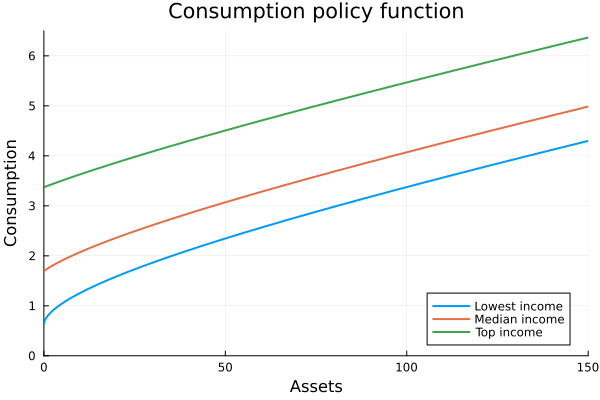

In [4]:
agrid = AM.âgrid
plot(agrid, AM.cf[1](agrid), title = "Consumption policy function", label = "Lowest income")
plot!(agrid, AM.cf[4](agrid),label = "Median income" )
plot!(agrid, AM.cf[7](agrid),label = "Top income" , legend = :bottomright, xlabel = "Assets", ylabel = "Consumption")
xlims!((0,150))
ylims!((0,6.5))

* And stationary distribution

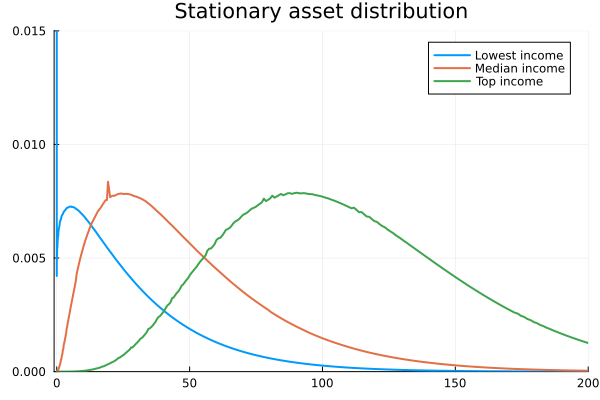

In [5]:
agrid = unique(AM.āθ̄[:,1])
ω_aθ = reshape(AM.ω̄[:,1],Ia,:)
ω_θ = sum(ω_aθ,dims =1)[:]

# Stationary distribution in assets 
plot(agrid,ω_aθ[:,1]./ω_θ[1],title = "Stationary asset distribution", label = "Lowest income")
plot!(agrid,ω_aθ[:,4]./ω_θ[4],label = "Median income" )
plot!(agrid,ω_aθ[:,7]./ω_θ[7],label = "Top income",legend=true)
xlims!((-1,200))
ylims!((0,0.015))

# 2 Constructing the Zeroth Order Approximation Object

First we need a struct to hold all of the parameters of the model

In [6]:

# Save the model parameters to be used in the functions F and G
@with_kw mutable struct ModelParams
    a_cutoff::Dict{Float64,Float64} = Dict{Float64,Float64}() 
    a̲::Float64 = 0.
    β::Float64 = 0.
    σ::Float64 = 0.
    θ::Vector{Float64} = zeros(1)
    α::Float64 = 0.
    δ::Float64 = 0.
    N̄::Float64 = 0.
    
    ρ_Θ::Matrix{Float64} = zeros(1)
    Σ_Θ::Matrix{Float64} = zeros(1)
end

para=ModelParams(a_cutoff = AM.a_cutoff, a̲ = AM.a̲, β = AM.β, σ = AM.σ, θ = AM.θ, α = AM.α, δ = AM.δ, N̄ = AM.N̄, ρ_Θ = ρ_Θ, Σ_Θ = Σ_Θ);


## 2.1. Preparing The Inputs

The user needs to give four sets of objects stored in the inputs object

In [7]:
inputs = Inputs();

A] Equilibrium conditions: Functions $F$ and $G$
* A function $F$ that maps $(a\_,x,x^e,\theta,\Theta,X)\to \mathcal{R}^{nx}$ that holds individual optimality.  Letting $\lambda_{i,t}= R_t u_c\left(c_{i,t}\right)$ be the shadow value of consumption then the model relations between idiosyncratic variables and aggregate variables can be described as follow: 
    - Agent's budget constraint: 
    $$
        R_t a_{i,t-1} + W_t \exp(\theta_{i,t}) - c_{i,t} - a_{i,t}  =0 
    $$
    - If $a > \underline{a} $, the Euler equation
    $$
        R_t \, \beta \, \mathbb{E}_{i, t} \lambda_{i,t+1} -  \lambda_{i,t} =0 
    $$
    - If $a = \underline{a} $, the credit constraint binds:
    $$
        a_{i,t} - \underline{a} = 0 
    $$ 

In [8]:
function F(para::ModelParams,θ,a_,x,X,xᵉ)
    @unpack a_cutoff,β,σ,a̲ = para

    #unpack variables
    a,λ  = x
    _,λᵉ = xᵉ
    R,W  = X

    u_c = λ/R 
    c = (u_c)^(-1/σ) #definition of λ
    
    ret = [R*a_+W*exp(θ)-c-a,
           β*λᵉ - u_c]
    if a_ < a_cutoff[θ] #check if agent is on borrowing constraint
        ret[2] = a̲-a
    end
    return ret
end

F (generic function with 1 method)

In [9]:
inputs.F = (θ,a_,x,X,xᵉ)->F(para,θ,a_,x,X,xᵉ)

#300 (generic function with 1 method)

* A function $G$ that maps $(A\_,X,\mathbb{E} X^{\prime},\Theta,\int x) \to \mathcal{R}^{Nx}$ that holds market clearing and FOC of homogeneous agents

In [10]:
function G(para::ModelParams,Ix,A_,X,Xᵉ,Θ)
    @unpack α,δ,N̄ = para
    Ia,_ = Ix
    R,W,C,Y,K = X
    K_, = A_
    TFP, = Θ
    #now perform operations
    rK = α*TFP*K_^(α-1)*N̄^(1-α)
    I  = K - (1-δ)*K_
    return [R - (1 - δ + rK),
            W - (1-α)TFP*K_^α*N̄^(-α),
            Y - TFP*K_^(α)*N̄^(1-α),
            Y - C - I,
            K - Ia]#
end

G (generic function with 1 method)

In [11]:
inputs.G = (Ix,A_,X,Xᵉ,Θ)->G(para,Ix,A_,X,Xᵉ,Θ)

#302 (generic function with 1 method)

B] Individual policy functions

* a list of policy functions `xf`. Each policy function maps $(a,\theta)\to \mathbb{R}$
* a list of names for the policy functions `xlab` stored as a vector of symbols
* the names for idiosyncratic states `alab`, as a vector of symbols
* definitions of splines (knot points and order)
* a grid on which policy functions (`aθ_sp`) and  distributions (`aθ_Ω`) are evaluated

In [12]:
function construct_individual_inputs!(AM::AiyagariModel, inputs::Inputs)
    @unpack λf,af= AM #then unpack equilibrium objects
    inputs.aknots,inputs.ka,inputs.aθ_sp,inputs.aθ_Ω,inputs.ℵ = get_grids(AM)
    inputs.xf=[af,λf]
    inputs.xlab=[:a,:λ]
    inputs.alab=[:a]
end

construct_individual_inputs! (generic function with 1 method)

In [13]:
construct_individual_inputs!(AM,inputs);

In [14]:
#Coarse Grid
inputs.aθ_sp

420×2 Matrix{Float64}:
   0.0         -1.35719
   0.00975821  -1.35719
   0.064959    -1.35719
   0.207316    -1.35719
   0.464378    -1.35719
   0.857763    -1.35719
   1.40599     -1.35719
   2.12557     -1.35719
   3.0315      -1.35719
   4.13767     -1.35719
   ⋮           
 353.76         1.10612
 371.531        1.10612
 389.827        1.10612
 408.654        1.10612
 428.016        1.10612
 447.918        1.10612
 468.366        1.10612
 489.363        1.10612
 500.0          1.10612

In [15]:
#Fine Grid
inputs.aθ_Ω

3500×2 Matrix{Float64}:
   0.0         -1.35719
   0.00200802  -1.35719
   0.0080321   -1.35719
   0.0180722   -1.35719
   0.0321284   -1.35719
   0.0502006   -1.35719
   0.0722889   -1.35719
   0.0983932   -1.35719
   0.128514    -1.35719
   0.16265     -1.35719
   ⋮           
 484.096        1.10612
 486.07         1.10612
 488.048        1.10612
 490.03         1.10612
 492.016        1.10612
 494.006        1.10612
 496.0          1.10612
 497.998        1.10612
 500.0          1.10612

C] Aggregate variables 
* Vector of steady state values `X̄`
* the names of aggregates `Xlab` stored as a vector of symbols
* the names of past agg. states that matter for equilibrium  `Alab`, as a vector of symbols
* the names of agg. variables that appear in individual problem `Qlab`, as a vector of symbols

In [16]:
function construct_X̄s!(AM::AiyagariModel,inputs::Inputs)
    @unpack α,δ,N̄,K2Y,Θ̄,Ia,R̄,W̄= AM 
    Y2K = 1/K2Y
    K2N = (Y2K/Θ̄)^(1/(α-1))
    K̄ = N̄*K2N
    Ȳ = Y2K*K̄
    C̄ = Ȳ - δ*K̄
    inputs.X̄=     [R̄,  W̄, C̄, Ȳ, K̄]
    inputs.Xlab = [:R,:W,:C,:Y,:K]
    inputs.Alab = [:K]
    inputs.Qlab = [:R,:W]
end

construct_X̄s! (generic function with 1 method)

In [17]:

construct_X̄s!(AM,inputs);

D] Risk processes and other steady-state objects
* histogram $\omega$ as a vector `ω̄` and the individual policy transition matrix `Λ` 
* parameters for $\Theta$ aggregate risk process such as `Θ̄`, `ρ_Θ`,and `Σ_Θ`
* transition matrix for $\theta$ as a matrix `πθ`

In [18]:
inputs.ω̄, inputs.Λ, inputs.πθ =  AM.ω̄, AM.Λ, AM.πθ;
inputs.Θ̄, inputs.ρ_Θ, inputs.Σ_Θ = ones(1)*AM.Θ̄,ρ_Θ,Σ_Θ;

## 2.2 Zeroth Order Approximation Object
Once the inputs object is constructed we can construct the zeroth order approximation

In [19]:
ZO = ZerothOrderApproximation(inputs);

The derivatives of F and G can both be precomputed

In [20]:
computeDerivativesF!(ZO,inputs)
computeDerivativesG!(ZO,inputs);

Derivatives of $G$ are evaluated at the steady state values

In [21]:
ZO.dG.X

5×5 Matrix{Float64}:
 1.0  0.0   0.0  0.0   0.0
 0.0  1.0   0.0  0.0   0.0
 0.0  0.0   0.0  1.0   0.0
 0.0  0.0  -1.0  1.0  -1.0
 0.0  0.0   0.0  0.0   1.0

Derivatives of $F$ are evaluated at each of the coarse gridpoints

In [22]:
ZO.dF.x[10]

2×2 Matrix{Float64}:
 -1.0   0.200348
 -0.0  -0.990099

Including Hessians

In [23]:
ZO.dF.xx[10]

2×2×2 Array{Float64, 3}:
[:, :, 1] =
 -0.0  -0.0
 -0.0  -0.0

[:, :, 2] =
 -0.0  -0.240367
 -0.0  -0.0

Basis matrices are stored as sparse matrices

In [24]:
ZO.Φ̃

420×420 SparseMatrixCSC{Float64, Int64} with 1260 stored entries:
⎡⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

In [25]:
ZO.Φ̃ᵉ

420×420 SparseMatrixCSC{Float64, Int64} with 8806 stored entries:
⎡⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠘⢦⡀⠀⠀⠀⠲⣤⡀⠀⠀⠐⠶⣄⠀⠀⠀⠰⢦⡀⠀⠀⠀⠤⣄⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠳⣦⠀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠳⣆⠀⠀⎥
⎢⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⡄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣆⠀⠀⠀⠈⠳⡄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣄⎥
⎢⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠘⠳⣆⡀⠀⠀⠘⢶⣄⠀⠀⠀⠲⢦⡀⠀⠀⠀⎥
⎢⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣤⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⎥
⎢⣀⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⢆⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⠀⠀⠀⠈⠳⠆⠀⠀⠀⠈⠳⠄⠀⠀⠀⠙⠦⎥
⎢⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠉⠳⣄⠀⠀⠈⠙⢦⡀⠀⠀⠈⠳⣤⠀⠀⠀⠛⢶⣄⠀⠀⠀⎥
⎢⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣆⡀⠀⠀⠉⠳⣄⠀⎥
⎢⣤⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣆⡀⠀⠀⠈⢳⣀⠀⠀⠀⠙⢆⡀⠀⠀⠈⠻⣆⠀⠀⠀⠈⠳⎥
⎢⠀⠻⢦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠈⠙⢦⡀⠀⠀⠉⠳⣄⡀⠀⠀⎥
⎢⠀⠀⠈⠛⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠳⣦⠀⎥
⎢⢦⡀⠀⠀⠈⠹⣦⡀⠀⠀⠈⠣⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⢻⣄⡀⠀⠀⠈⢣⣀⠀⠀⠀⠙⣂⡀⠀⠀⠈⠛⎥
⎢⠀⠙⢦⡀⠀⠀⠈⠹⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠉⠳⣄⠀⠀⠈⠙⢦⡀⠀⠀⎥
⎢⠀⠀⠀⠙⢦⡀⠀⠀⠀⠻⢦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⎥
⎢⠲⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠱⢦⡀⠀⠀⠈⠷⣄⠀⠀⠀⠹⢤⡀⠀⠀⠈⠡⣄⠀⠀⠀⠈⢥⣀⠀⠀⠀⠉⎥
⎢⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠛⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠙⠳⣄⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠹⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⡀⠀⠀⠈⠳⣄⎥
⎢⠙⣦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠀⠳⣦⡀⠀⠀⠘⠲⣄⠀⠀⠀⠱⢦⡀⠀⠀⠈⠷⣄⠀⠀⠀⠈⎥
⎢⠀⠀⠹⢦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠀⠻⢦⡀⠀⠀⠈⠳⣄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠳⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠛⢦⠀⠀⠀⠈⠳⡄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠛⣦⠀⠀⠀⠈⠳⡄⠀⠀⠀⠙⢦⡀⠀⠀⠈⠻⣦⎦

In [26]:
ZO.Φ

420×3500 SparseMatrixCSC{Float64, Int64} with 10500 stored entries:
⎡⠉⠉⠓⠒⠒⠒⠒⠦⠤⠤⠤⠤⣄⣀⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠛⠒⠒⠒⠒⠦⠤⠤⠤⢤⣄⣀⣀⣀⣀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⎦

Can check that steady state policy rules hold

In [27]:
j = 68 #pick some element of course grid
a_,θ = ZO.aθ_sp[j,:]
x = (ZO.x̄*ZO.Φ̃)[:,j]
xᵉ = (ZO.x̄*ZO.Φ̃ᵉ)[:,j]

inputs.F(θ,a_,x,ZO.X̄,xᵉ)

2-element Vector{Float64}:
  0.0
 -0.0011596391690994468

Can also check $G$ equations in steady state

In [28]:
Ix = ZO.x̄*ZO.Φ*ZO.ω̄
Ā = ZO.P*ZO.X̄
inputs.G(Ix,Ā,ZO.X̄,ZO.X̄,[AM.Θ̄])

5-element Vector{Float64}:
  2.220446049250313e-16
  4.440892098500626e-16
  4.440892098500626e-16
 -4.440892098500626e-16
 -0.0005020149903884885

# 3 First Order Approximation

Once the zeroth order approximation is constructed.  Constructing the first order approximation is straightforward

In [29]:
#define the FirstOrderApproximation class
T=300 #truncation length
FO = FirstOrderApproximation(ZO,T);

Next compute the derivatives

In [30]:

#computes the first order derivatives in the direction of the aggregate shocks
compute_Θ_derivatives!(FO)

In [31]:
#bechmarking the code 
@benchmark compute_Θ_derivatives!(FO)

BenchmarkTools.Trial: 53 samples with 1 evaluation.
 Range (min … max):  90.562 ms … 114.935 ms  ┊ GC (min … max): 3.49% … 8.17%
 Time  (median):     93.779 ms               ┊ GC (median):    4.44%
 Time  (mean ± σ):   94.389 ms ±   3.336 ms  ┊ GC (mean ± σ):  4.75% ± 1.44%

                █    ▂    ▂                                     
  ▆▁▁▁▁▁▄▁▁▁▄▆▆████▄▄█▄▆▄▆█▄▄▄▁▁▆▄▆▁▄▁▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  90.6 ms         Histogram: frequency by time          101 ms <

 Memory estimate: 152.83 MiB, allocs estimate: 142339.

How does $\hat K_t$ look?

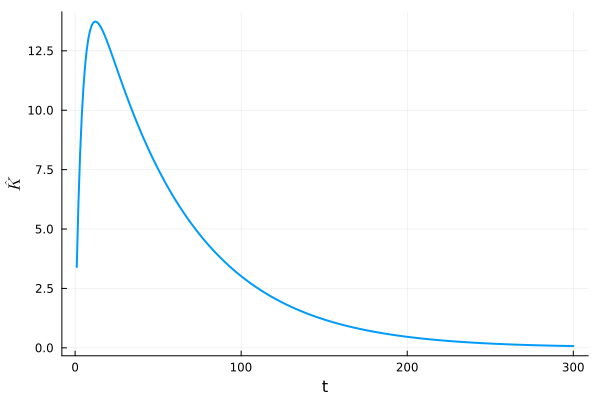

In [32]:
iK = (1:ZO.n.X)[inputs.Xlab.==:K][1]
plot(1:T,FO.X̂t[iK,:],xlabel="t",ylabel=L"\hat K")

Can also compute derivatives of individual policies with respect to shocks

In [33]:
compute_x_Θ_derivatives!(FO)

In [34]:
@benchmark compute_x_Θ_derivatives!(FO)

BenchmarkTools.Trial: 40 samples with 1 evaluation.
 Range (min … max):  116.833 ms … 162.805 ms  ┊ GC (min … max):  9.81% … 35.94%
 Time  (median):     123.345 ms               ┊ GC (median):    13.66%
 Time  (mean ± σ):   126.298 ms ±  10.029 ms  ┊ GC (mean ± σ):  15.65% ±  5.42%

  █ ▁ █▄▁▄▁▄  █                                                  
  █▁█▆██████▆▆█▁▆▆▁▆▆▁▁▁▁▁▁▁▁▆▆▁▁▆▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▆ ▁
  117 ms           Histogram: frequency by time          163 ms <

 Memory estimate: 345.96 MiB, allocs estimate: 230550.

* Can use $\hat x_t(a,\theta)$ to determine distributional effects

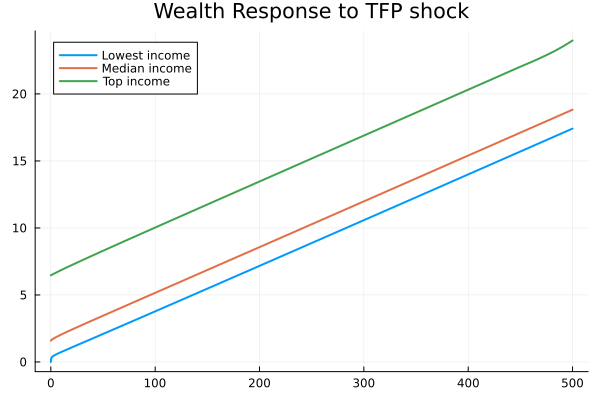

In [35]:
â_0 = (FO.x̂_Θt[1][1]*ZO.Φ)[1,:] #resposnse of wealth to TFP shock
â_0 = reshape(â_0,:,ZO.n.θ) 
plot(agrid,â_0[:,1],title = "Wealth Response to TFP shock", label = "Lowest income")
plot!(agrid,â_0[:,4],label = "Median income" )
plot!(agrid,â_0[:,7],label = "Top income",legend=true)

In [36]:
#can also integrate it up over stationary distribution
dot(â_0,ZO.ω̄)

3.4052229923347803

In [37]:
#compare to
FO.X̂_Θt[1][iK,1] #K̂_0

3.405222992334813

# 4 Second Order Approximation

In [38]:
#define the FirstOrderApproximation class
SO = SecondOrderApproximation(FO=FO) ; 

In [39]:
#computes the first order derivatives in the direction of the aggregate shocks
computeSecondOrder!(SO); 

Can also benchmark the second order code

In [40]:
@benchmark computeSecondOrder!(SO)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  627.752 ms … 723.564 ms  ┊ GC (min … max):  6.96% … 18.48%
 Time  (median):     668.870 ms               ┊ GC (median):     8.71%
 Time  (mean ± σ):   673.671 ms ±  34.710 ms  ┊ GC (mean ± σ):  10.53% ±  4.52%

  ▁  ▁                    █  ▁      ▁                      ▁  ▁  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█ ▁
  628 ms           Histogram: frequency by time          724 ms <

 Memory estimate: 699.16 MiB, allocs estimate: 3018616.

## 4.1 Simulating a Path of Shocks

In [41]:
Tsim=50

X_ΘΘtk = compute_XZZjk(SO,1,1,1:Tsim)
#X_ZZ[0] correpond to second order approximation of a shock in the first period (0 lag)  
X_ΘΘtk[0] = SO.X̂_ΘΘ[1,1];

# Compute the size of aggregate shocks (in standard deviation):
shock   = 1         # use a shock of a size 1 sd of aggregate shock standard deviation
path    = zeros(Tsim)
path[1] = shock

# Compute the Impulse Response Functionb 
KtHA=getPath(SO,path,iK,X_ΘΘtk)
KtHA.t = 1:Tsim

1:50

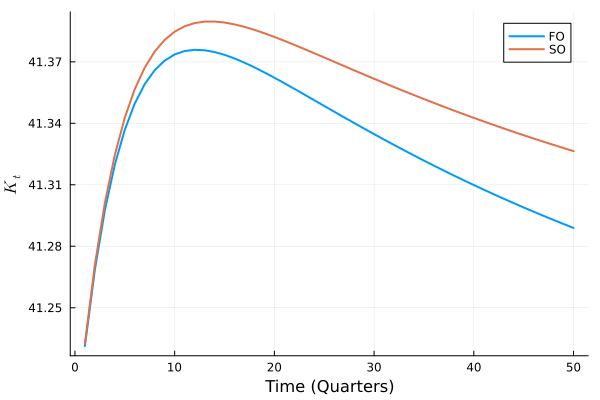

In [42]:
plot(KtHA.t,KtHA.FO,xlabel="Time (Quarters)",ylabel=L"K_t",label="FO")
plot!(KtHA.t,KtHA.X,label = "SO", legend = true)

## 4.2 Comparison to ABRS

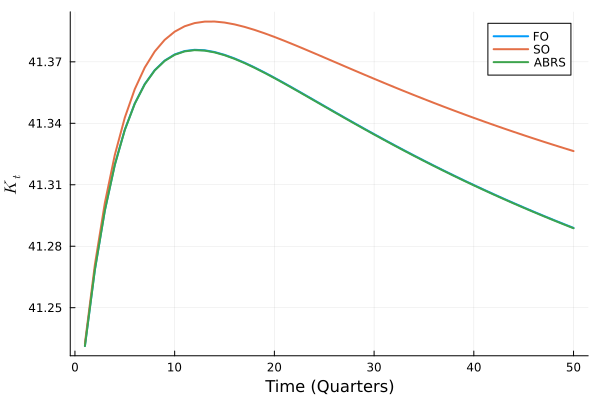

In [43]:
dKt,dRt,dWt =doABRS(AM,ZO.X̄,ZO.x̄,T,Σ_Θ,ρ_Θ)

KtABRS = getPathABRS(path,dKt,ZO.X̄[iK])
KtABRS.t=1:Tsim
plot!(KtABRS.t,KtABRS.X,label = "ABRS", legend = true)